## **Diabetes Prediction**

### **Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import warnings

warnings.simplefilter("ignore", category=UserWarning)

### **Data Preprocessing**

In [ ]:
data = pd.read_csv('../Diabetes.csv')
data['Sex'] = data['Sex'].map({'female': 0, 'male': 1})
label_encoder = LabelEncoder()
data['Prediction'] = label_encoder.fit_transform(data['Prediction'])

In [3]:
data.head()

,S.No,Age,Sex,Fasting,Post Prandial,GTT 1/2 Hr,GTT 1 Hr,GTT 1-1/2 Hr,GTT 2 Hr,HbA1C,MGV,Insulin,T.Cholesterol,TGL,HDL,LDL,Chol/HDL.Ratio,Apolipoprotein-A1,Apolipoprotein-B,P,BUN,Serum Creatinine,Microalbumin,UrineCreatinine,Alb/Crea Ratio,SGOT,SGPT,Alk.Phosphate,T.Protein,Albumin,T.Bilirubin,D.Bilirubin,Hemoglobin,TSH3,UricAcid,Homosystiene,hs-CRP,SOD,LPO,Apo B/Apo,Prediction
0,1,38,0,87,78.826087,146.000000,129.000000,112.000000,85.000000,5.8,120.0,6.200000,146,46,38.0,89.000000,3.800000,0,0.466667,0.046667,7.0,0.6,19.2,62.30,30.80,16,27.0,69.0,8.0,3.9,0.40,0.10,10.9,1.31,3.000000,13.210000,0.651765,1.554,0,0,1
1,2,33,0,119,95.000000,89.000000,85.000000,5.500000,111.000000,6.9,174.0,47.000000,50,99,3.5,122.060403,4.468707,0,7.000000,0.700000,14.6,93.9,15.5,22.00,33.00,69,7.1,3.5,0.4,0.1,12.10,1.50,2.7,15.85,4.158503,13.543922,0.651765,1.554,0,0,1
2,3,45,0,87,0.000000,105.000000,110.000000,80.000000,78.000000,5.7,117.0,4.800000,160,58,49.0,89.000000,3.300000,0,0.000000,0.000000,10.0,0.7,9.4,25.60,36.70,28,34.0,176.0,7.9,3.8,0.50,0.10,14.1,2.74,3.000000,11.510000,0.000000,0.000,0,0,1
3,4,44,0,89,96.000000,179.688406,203.391304,196.184783,177.112676,6.2,131.0,3.400000,151,65,60.0,83.000000,4.468707,0,0.466667,0.046667,7.0,0.7,1.6,23.63,7.00,25,30.0,83.0,7.4,3.7,0.55,0.20,9.0,2.71,3.200000,7.450000,0.651765,1.554,0,0,1
4,5,44,1,97,78.826087,215.000000,202.000000,127.000000,77.000000,5.4,109.0,7.524528,186,67,67.0,108.000000,2.700000,0,0.466667,0.046667,15.0,1.0,29.9,162.10,18.45,27,35.0,95.0,7.8,3.8,0.65,0.17,14.9,5.52,3.800000,13.543922,0.651765,1.554,0,0,1


In [4]:
data.describe()

,S.No,Age,Sex,Fasting,Post Prandial,GTT 1/2 Hr,GTT 1 Hr,GTT 1-1/2 Hr,GTT 2 Hr,HbA1C,MGV,Insulin,T.Cholesterol,TGL,HDL,LDL,Chol/HDL.Ratio,Apolipoprotein-A1,Apolipoprotein-B,P,BUN,Serum Creatinine,Microalbumin,UrineCreatinine,Alb/Crea Ratio,SGOT,SGPT,Alk.Phosphate,T.Protein,Albumin,T.Bilirubin,D.Bilirubin,Hemoglobin,TSH3,UricAcid,Homosystiene,hs-CRP,SOD,LPO,Apo B/Apo,Prediction
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.00000,150.000000,150.000000,150.000000,150.000000,150.0,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.0,150.0,150.000000
mean,75.500000,46.740000,0.413333,115.900000,78.826087,179.688406,203.391304,196.184783,177.112676,6.764000,148.310811,7.524528,180.82000,146.826667,42.430000,122.060403,4.468707,0.0,0.466667,0.046667,9.237333,1.534000,10.270345,79.865822,12.922261,22.520000,36.720667,84.534000,7.608000,4.033333,0.651267,0.180267,13.301333,3.205102,4.158503,13.543922,0.651765,1.554000,0.0,0.0,1.000000
std,43.445368,9.787974,0.494081,40.588085,46.037285,57.009690,77.480410,87.141771,89.054323,1.595349,45.559733,4.382820,34.76712,144.422235,10.158316,30.841275,1.240199,0.0,0.554017,0.055402,2.464392,7.594309,12.256313,50.536015,17.106680,12.016052,13.130298,26.269568,0.679076,0.512091,0.977075,0.154272,2.362344,3.636707,1.282502,7.318496,0.485002,1.844877,0.0,0.0,0.819232
min,1.000000,28.000000,0.000000,80.000000,0.000000,0.000000,0.000000,0.000000,77.000000,4.800000,91.000000,0.000000,50.00000,40.000000,3.500000,52.000000,2.300000,0.0,0.000000,0.000000,6.000000,0.600000,0.100000,9.100000,0.100000,12.000000,7.100000,3.500000,0.400000,0.100000,0.300000,0.100000,2.700000,0.190000,2.600000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
25%,38.250000,40.250000,0.000000,92.000000,78.826087,146.000000,143.500000,126.250000,102.250000,5.700000,117.000000,7.524528,156.00000,80.250000,36.000000,102.250000,3.600000,0.0,0.466667,0.046667,7.000000,0.800000,1.950000,41.297500,3.970000,16.000000,30.000000,66.000000,7.400000,3.800000,0.400000,0.100000,12.100000,1.562500,3.200000,13.543922,0.651765,1.554000,0.0,0.0,0.000000
50%,75.500000,46.000000,0.000000,100.500000,78.826087,179.688406,203.391304,195.000000,154.500000,6.150000,131.000000,7.524528,181.50000,106.500000,42.000000,118.000000,4.300000,0.0,0.466667,0.046667,9.000000,0.900000,5.650000,69.350000,9.105000,19.000000,35.000000,83.000000,7.700000,4.000000,0.500000,0.100000,13.400000,2.290000,3.900000,13.543922,0.651765,1.554000,0.0,0.0,1.000000
75%,112.750000,53.000000,1.000000,122.000000,78.826087,204.750000,244.000000,251.500000,223.000000,7.300000,165.250000,7.524528,198.50000,157.000000,48.000000,138.750000,5.200000,0.0,0.466667,0.046667,10.000000,1.000000,14.050000,109.500000,12.922261,24.000000,39.000000,98.750000,7.900000,4.400000,0.600000,0.200000,14.700000,3.205102,4.800000,13.543922,0.651765,1.554000,0.0,0.0,2.000000
max,150.000000,73.000000,1.000000,347.000000,390.000000,440.000000,530.000000,577.000000,591.000000,13.600000,344.000000,47.000000,266.00000,1262.000000,69.000000,202.000000,10.100000,0.0,7.000000,0.700000,17.000000,93.900000,84.100000,351.500000,140.890000,95.000000,100.000000,176.000000,8.200000,4.900000,12.100000,1.500000,18.300000,27.860000,13.000000,50.000000,4.600000,23.310000,0.0,0.0,2.000000


### **Feature Selection, Model Definition and Evaluation**

In [5]:
feature_columns = data.columns.difference(['ID No', 'Name', 'Prediction']).tolist()

In [6]:
accuracy_results = []
column_importance = {col: 0 for col in feature_columns}

In [ ]:
def evaluate_model(selected_columns):
    X = data[selected_columns].values
    y = data['Prediction'].values

    y_encoded = (y == 'DM').astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    n_qubits = len(selected_columns)
    dev = qml.device('default.qubit', wires=n_qubits)

    params = np.random.normal(0, np.pi, size=n_qubits * 3)

    @qml.qnode(dev)
    def quantum_circuit(params, x):
        for i in range(n_qubits):
            qml.RX(x[i], wires=i)
            qml.RZ(params[i], wires=i)

        for i in range(n_qubits):
            for j in range(i + 1, n_qubits):
                target = (j + 1) % n_qubits
                if target != i and target != j:
                    qml.Toffoli(wires=[i, j, target])

        for i in range(n_qubits):
            qml.RX(params[n_qubits + i], wires=i)
            qml.RZ(params[2 * n_qubits + i], wires=i)

        return qml.expval(qml.PauliZ(0))

    def cost(params, X_batch, y_batch):
        predictions = np.array([quantum_circuit(params, x) for x in X_batch])
        return np.mean((predictions - y_batch) ** 2)

    opt = qml.GradientDescentOptimizer(stepsize=0.1)

    for epoch in range(100):

        for i in range(0, len(X_train), 32):
            X_batch = X_train[i:i+32]
            y_batch = y_train[i:i+32]
            params = opt.step(lambda p: cost(p, X_batch, y_batch), params)

    y_pred = np.array([quantum_circuit(params, X_test[i])
                      for i in range(len(X_test))])
    y_pred = (y_pred > 0).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [8]:
max_columns = len(feature_columns)
iterations = 5

In [9]:
sample = 1
for num_columns in range(1, max_columns + 1):
    for _ in range(iterations):
        if sample < 21:
            selected_columns = np.random.choice(feature_columns, size=num_columns, replace=False)
            
            accuracy = evaluate_model(selected_columns)
            
            if accuracy > 0.5 and len(selected_columns) > 2:
                
                print(f"Sample {sample}")
                print(f"\tNumber of columns: {len(selected_columns)}")
                print(f"\tAccuracy: {accuracy:.2%}")
                accuracy_results.append((selected_columns, accuracy))
                sample = sample + 1
                for col in selected_columns:
                    column_importance[col] += accuracy

Sample 1
	Number of columns: 3
	Accuracy: 53.33%
Sample 2
	Number of columns: 3
	Accuracy: 76.67%
Sample 3
	Number of columns: 5
	Accuracy: 86.67%
Sample 4
	Number of columns: 5
	Accuracy: 100.00%
Sample 5
	Number of columns: 6
	Accuracy: 96.67%
Sample 6
	Number of columns: 6
	Accuracy: 100.00%
Sample 7
	Number of columns: 7
	Accuracy: 93.33%
Sample 8
	Number of columns: 7
	Accuracy: 93.33%
Sample 9
	Number of columns: 7
	Accuracy: 76.67%
Sample 10
	Number of columns: 9
	Accuracy: 53.33%
Sample 11
	Number of columns: 9
	Accuracy: 100.00%
Sample 12
	Number of columns: 9
	Accuracy: 83.33%
Sample 13
	Number of columns: 10
	Accuracy: 70.00%
Sample 14
	Number of columns: 10
	Accuracy: 70.00%
Sample 15
	Number of columns: 10
	Accuracy: 90.00%
Sample 16
	Number of columns: 10
	Accuracy: 100.00%
Sample 17
	Number of columns: 11
	Accuracy: 90.00%
Sample 18
	Number of columns: 11
	Accuracy: 63.33%
Sample 19
	Number of columns: 12
	Accuracy: 73.33%
Sample 20
	Number of columns: 12
	Accuracy: 70.0

### **Results and Analysis**

#### Feature sets by accuracy

In [10]:
accuracy_results = pd.DataFrame(accuracy_results, columns=["Features", "Accuracy"])
sorted_results = accuracy_results.sort_values(by=["Accuracy"], ascending=False)
sorted_results["No. Features"] = sorted_results["Features"].apply(len)

print(sorted_results)

                                             Features  Accuracy  No. Features
3   [Apo B/Apo, P, Homosystiene, UrineCreatinine, ...  1.000000             5
15  [Serum Creatinine, LDL, TGL, Albumin, S.No, HD...  1.000000            10
10  [hs-CRP, HDL, P, LDL, Albumin, Apolipoprotein-...  1.000000             9
5   [Apo B/Apo, Chol/HDL.Ratio, HbA1C, Insulin, SG...  1.000000             6
4   [Alb/Crea Ratio, SGOT, GTT 1-1/2 Hr, Microalbu...  0.966667             6
7    [S.No, T.Protein, BUN, TGL, Apo B/Apo, MGV, SOD]  0.933333             7
6   [Apolipoprotein-A1, SGOT, Insulin, GTT 1 Hr, A...  0.933333             7
14  [Alk.Phosphate, T.Cholesterol, UricAcid, Micro...  0.900000            10
16  [MGV, LPO, Post Prandial, Albumin, UrineCreati...  0.900000            11
2   [HDL, Homosystiene, Alk.Phosphate, GTT 1 Hr, I...  0.866667             5
11  [SOD, Post Prandial, Alk.Phosphate, Age, GTT 1...  0.833333             9
1                    [GTT 2 Hr, Microalbumin, hs-CRP]  0.766667 

#### Visualization of Feature sets by Accuracy

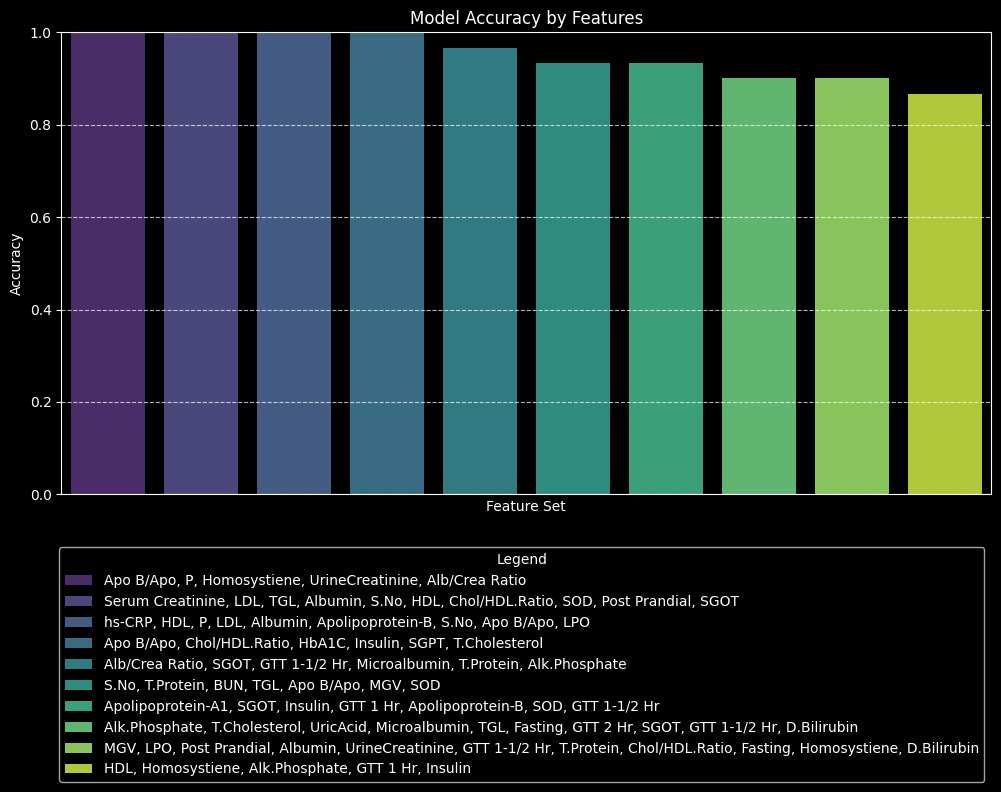

In [11]:
accuracy_results = pd.DataFrame(accuracy_results, columns=["Features", "Accuracy"])
sorted_results = accuracy_results.sort_values(by=["Accuracy"], ascending=False)
sorted_results["Features"] = sorted_results["Features"].apply(lambda x: ', '.join(x))[:10]

plt.figure(figsize=(12, 6))
sns.barplot(x="Features", y="Accuracy", data=sorted_results, palette="viridis", hue="Features")
plt.ylabel('Accuracy')
plt.xlabel('Feature Set')
plt.title('Model Accuracy by Features')
plt.ylim(0, 1)  
plt.xticks([])  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Legend', loc='upper right', bbox_to_anchor=(1, -0.1))
plt.show()